In [1]:
%load_ext autoreload
%autoreload 2

In [98]:
import random as rd
import numpy as np
import torch
from torch.utils.data import DataLoader
import gymnasium as gym
from transformers import AutoImageProcessor

In [96]:
from torch.utils.data import DataLoader, Dataset
from transformers import AutoImageProcessor
from stable_baselines3 import PPO
from stable_baselines3.common import env_checker


from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.modeling.agents.rl_agent_feature_extractor import CustomResNetFeatureExtractor
from uav_active_sensing.config import DEVICE
from uav_active_sensing.plots import visualize_tensor

In [97]:
class SingleImageDataset(Dataset):
    def __init__(self, original_dataset: Dataset, index: int):
        self.image, self.label = original_dataset[index]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.image, self.label

In [5]:
class RewardFunction:
    def __init__(self, model: ActViTMAEForPreTraining, num_samples: int, patch_size: int, generator: torch.Generator, reward_increase: bool):
        self.model= model
        self.num_samples = num_samples
        self.generator = generator
        self.patch_size = patch_size
        self.last_reward = 0
        self.reward_increase = reward_increase


    def __call__(self, img: torch.Tensor, sampled_img: torch.Tensor, masking_ratio: float) -> float:

        batch_reward = torch.zeros(self.num_samples, dtype=torch.float32)


        for i in self.num_samples:
            masked_sampled_img = self.sampled_img_random_masking(sampled_img, masking_ratio=masking_ratio)
            with torch.no_grad():
                outputs = self.model(img, masked_sampled_img)
            loss = outputs.loss
            reward_i = 1 / (1 + loss)
            batch_reward[i] = reward_i

        new_reward = batch_reward.sum().item()
        if self.reward_increase:
            new_reward = new_reward - self.last_reward
            self.last_reward = new_reward

        return new_reward
    
    def sampled_img_random_masking(self, sampled_img: torch.Tensor, masking_ratio: float) -> torch.Tensor:

        B, C, H, W = sampled_img.shape
        x = torch.clone(sampled_img)
        x = x.permute(0, 2, 3, 1)

        kc, kh = self.patch_size, self.patch_size  # kernel size
        dc, dh = self.patch_size, self.patch_size  # stride

        patches = x.unfold(1, kc, dc).unfold(2, kh, dh)
        nan_mask = torch.isnan(patches)
        patch_nan_mask = nan_mask.any(dim=(3, 4, 5))
        valid_patches = ~patch_nan_mask
        valid_indices = torch.nonzero(valid_patches, as_tuple=True)

        num_valid = valid_indices[0].shape[0]  # Count of valid patches, error
        num_to_mask = int(masking_ratio * num_valid)  # Number of patches to mask

        mask_indices = torch.randperm(num_valid, generator=self.generator)[:num_to_mask]
        selected_patches = tuple(idx[mask_indices] for idx in valid_indices)  # Extract selected patch indices

        # Apply NaN masking
        patches[selected_patches] = float('nan')

        # Reassemble image from patches
        reconstructed = patches.permute(0, 3, 1, 4, 2, 5).view(B, C, H, W)

        return reconstructed

In [99]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)  # TODO: Download this in advance
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
random_index = rd.randint(0, len(tiny_imagenet_train_dataset) - 1)
single_image_dataset = SingleImageDataset(tiny_imagenet_train_dataset, random_index)
tiny_imagenet_train_loader = DataLoader(single_image_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")  # TODO: Download this in advance
reward_function = RewardFunction(mae_model, False)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization

### Test random movement

In [100]:
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function, seed=45, patch_size=16 * 2)
env = ImageExplorationEnv(env_config)

In [101]:
env_checker.check_env(env)

/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [102]:
# # Test starting position dist
# mean_h = 0
# mean_w = 0


# n = 100_000
# for i in range (n):
#   env.reset()
#   h, w = env._sensor_pos[0].cpu().numpy()
#   norm_h = (h - (env.img_height//2)) / (env.img_height//2)
#   norm_w = (w - (env.img_width//2)) / (env.img_width//2)

#   mean_h += norm_h
#   mean_w += norm_w

# mean_h = mean_h / n
# mean_w = mean_w / n

# print(mean_h, mean_w)

In [145]:

env.reset()
for j in range(128):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)

### Random masking of sampled image

In [148]:
generator = torch.Generator().manual_seed(1230)

In [161]:
B, C, H, W = env.sampled_img.shape
patch_size = 16
masking_ratio = 0.5
x = torch.clone(env.sampled_img)
x = x.permute(0, 2, 3, 1)

num_patches_H = H // patch_size
num_patches_W = W // patch_size

kc, kh, kw = patch_size, patch_size, patch_size  # kernel size
dc, dh, dw = patch_size, patch_size, patch_size  # stride

patches = x.unfold(1, kc, dc).unfold(2, kh, dh)
nan_mask = torch.isnan(patches)
patch_nan_mask = nan_mask.any(dim=(3, 4, 5))
valid_patches = ~patch_nan_mask
valid_indices = torch.nonzero(valid_patches, as_tuple=True)

num_valid = valid_indices[0].shape[0]  # Count of valid patches, error
num_to_mask = int(masking_ratio * num_valid)  # Number of patches to mask

mask_indices = torch.randperm(num_valid, generator=generator)[:num_to_mask]
selected_patches = tuple(idx[mask_indices] for idx in valid_indices)  # Extract selected patch indices

# Apply NaN masking
patches[selected_patches] = float('nan')
reconstructed = patches.permute(0, 3, 1, 4, 2, 5).view(B, C, num_patches_H * patch_size, num_patches_W * patch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3585434].


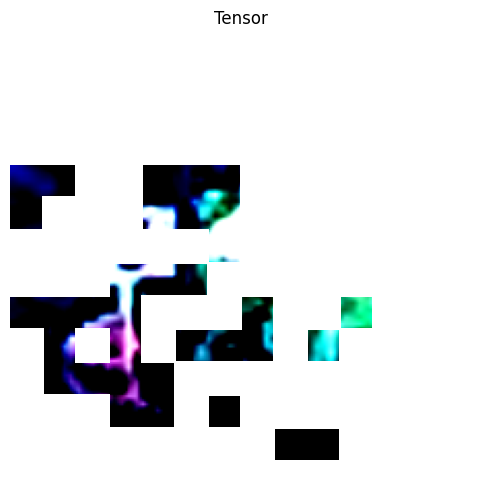

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3585434].


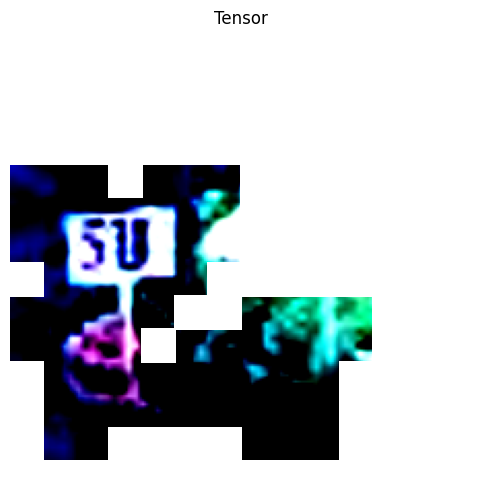

In [162]:
visualize_tensor(reconstructed)
visualize_tensor(env.sampled_img)

In [103]:
def sampled_img_random_masking(sampled_img: torch.Tensor, masking_ratio: float, generator: torch.Generator) -> torch.Tensor:

    B, C, H, W = sampled_img.shape
    patch_size = 16
    x = torch.clone(sampled_img)
    x = x.permute(0, 2, 3, 1)

    num_patches_H = H // patch_size
    num_patches_W = W // patch_size

    kc, kh = patch_size, patch_size  # kernel size
    dc, dh = patch_size, patch_size  # stride

    patches = x.unfold(1, kc, dc).unfold(2, kh, dh)
    nan_mask = torch.isnan(patches)
    patch_nan_mask = nan_mask.any(dim=(3, 4, 5))
    valid_patches = ~patch_nan_mask
    valid_indices = torch.nonzero(valid_patches, as_tuple=True)

    num_valid = valid_indices[0].shape[0]  # Count of valid patches, error
    num_to_mask = int(masking_ratio * num_valid)  # Number of patches to mask

    mask_indices = torch.randperm(num_valid, generator=generator)[:num_to_mask]
    selected_patches = tuple(idx[mask_indices] for idx in valid_indices)  # Extract selected patch indices

    # Apply NaN masking
    patches[selected_patches] = float('nan')

    # Reassemble image from patches
    reconstructed = patches.permute(0, 3, 1, 4, 2, 5).view(B, C, num_patches_H * patch_size, num_patches_W * patch_size)

    return reconstructed

### Test kernel size increase

In [ ]:
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)

In [8]:

env.reset()

for i in range(env.img_height // env.sensor_height // 2 - 1):
    sample_action = np.array([[0, 0, 1] for i in range(env.batch_size)])
    env.step(sample_action)
    # env._sensor_pos = env.sensor_max_pos_from_kernel_size
    # print(env._kernel_size)
    # print(env.sensor_max_pos_from_kernel_size)
    # print(env.fov_bbox)

for k in range(env.batch_size):
    visualize_tensor(env.img[k])
    visualize_tensor(env.sampled_img[k])

### Test deterministic behaviour for a given seed-

In [33]:
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)
env.reset()
first_run_actions = []
for j in range(5):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)
    first_run_actions.append(sample_action)

first_run = env.sampled_img.detach().clone()

env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)
second_run_actions = []
env.reset()
for j in range(5):
    sample_action = env.action_space.sample()
    # print(sample_action)
    # print(env._denormalize_action(torch.from_numpy(sample_action)))
    env.step(sample_action)
    second_run_actions.append(sample_action)

second_run = env.sampled_img.detach().clone()

In [ ]:
# Images shoud be identical if the sampling is deterministic (fixed seed)

for j in range(5):
    print((first_run_actions[j] == second_run_actions[j]).all())

for k in range(env.batch_size):
    visualize_tensor(first_run[k])
    visualize_tensor(second_run[k])
    print("-" * 50)